In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions

In [2]:
# Ensure the 'ucimlrepo' package is installed
#pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [3]:
# Fetch the dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets

In [4]:
# Data Inspection

# Print dataset metadata and variable information for reference
print(heart_disease.metadata)
print(heart_disease.variables)

# Display the first few rows of the data and summary statistics
print("First few rows of the feature data (X):")
print(X.head())
print("\nFirst few rows of the target data (y):")
print(y.head())
print("\nSummary statistics of the feature data (X):")
print(X.describe())
print("\nData types and non-null counts of the feature data (X):")
print(X.info())

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [ ]:
print("The dataset consists of 303 instances and 13 main features")

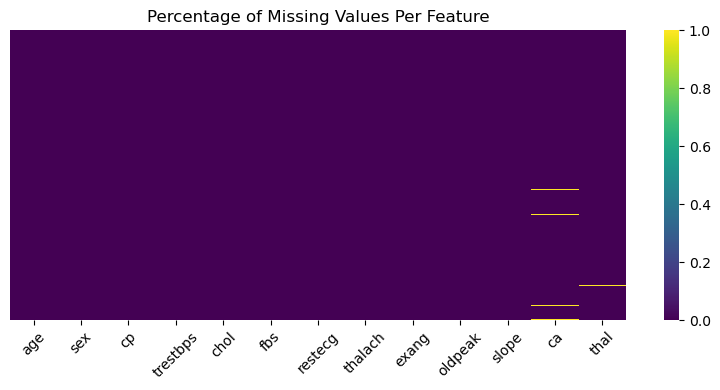

In [5]:
# Visualize missing values
plt.figure(figsize=(8, 4))
sns.heatmap(X.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Percentage of Missing Values Per Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print("The heatmap visualization primarily reveals that the features 'ca' and 'thal' contain missing values that need to be addressed before predictive modeling, while other features in the dataset have complete data.")


In [6]:
# Handling missing values
X.loc[:, 'ca'] = X['ca'].fillna(X['ca'].median())
X.loc[:, 'thal'] = X['thal'].fillna(X['thal'].mode()[0])

In [7]:
# Feature Exploration

# Convert the target series into a binary classification problem
y_binary = y['num'].apply(lambda x: 1 if x > 0 else 0)
#y_binary = y.apply(lambda x: 1 if x > 0 else 0)

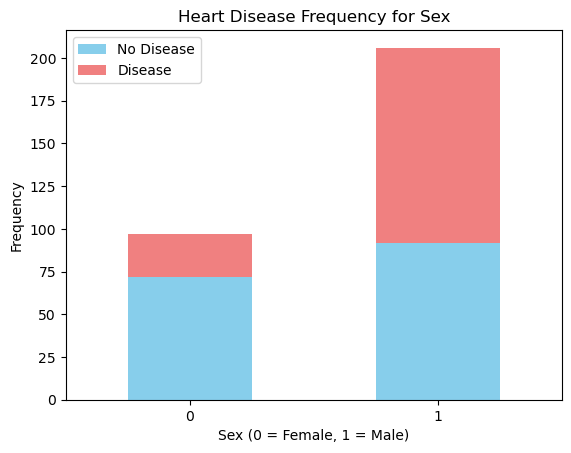

In [8]:
# Stacked Bar Chart for Categorical Feature Comparison: for 'sex' (gender) feature
cross_tab = pd.crosstab(X['sex'], y_binary)
cross_tab.plot(kind='bar', stacked=True, color=['skyblue', 'lightcoral'])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Frequency')
plt.legend(['No Disease', 'Disease'])
plt.xticks(rotation=0)
plt.show()

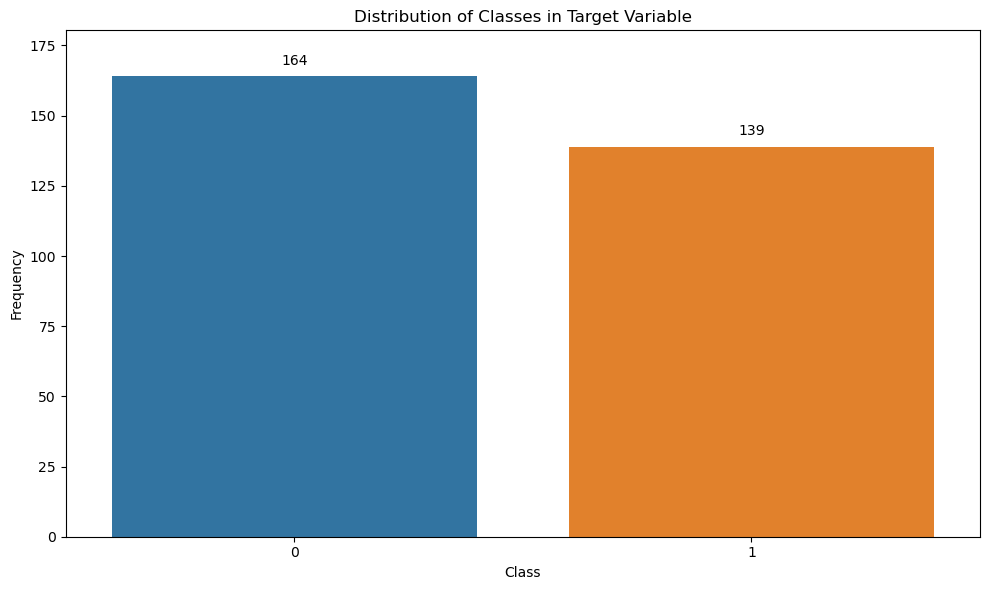

In [9]:
# Class Distribution Plot
class_counts = y_binary.value_counts()
plt.figure(figsize=(10, 6))  # Increase the figure size to give more room
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in Target Variable')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Annotate the bars with the class counts
for i in range(class_counts.shape[0]):
    plt.text(
        i, 
        class_counts.values[i] + 3,  # Slightly above the bar top
        class_counts.values[i], 
        ha='center', 
        va='bottom',
        color='black'  # Ensure the text color stands out against the bar
    )

plt.ylim(0, max(class_counts.values) * 1.1)  # Increase y limit for text annotation space
plt.tight_layout()  # Adjust layout to prevent any overlap or cutting off
plt.show()

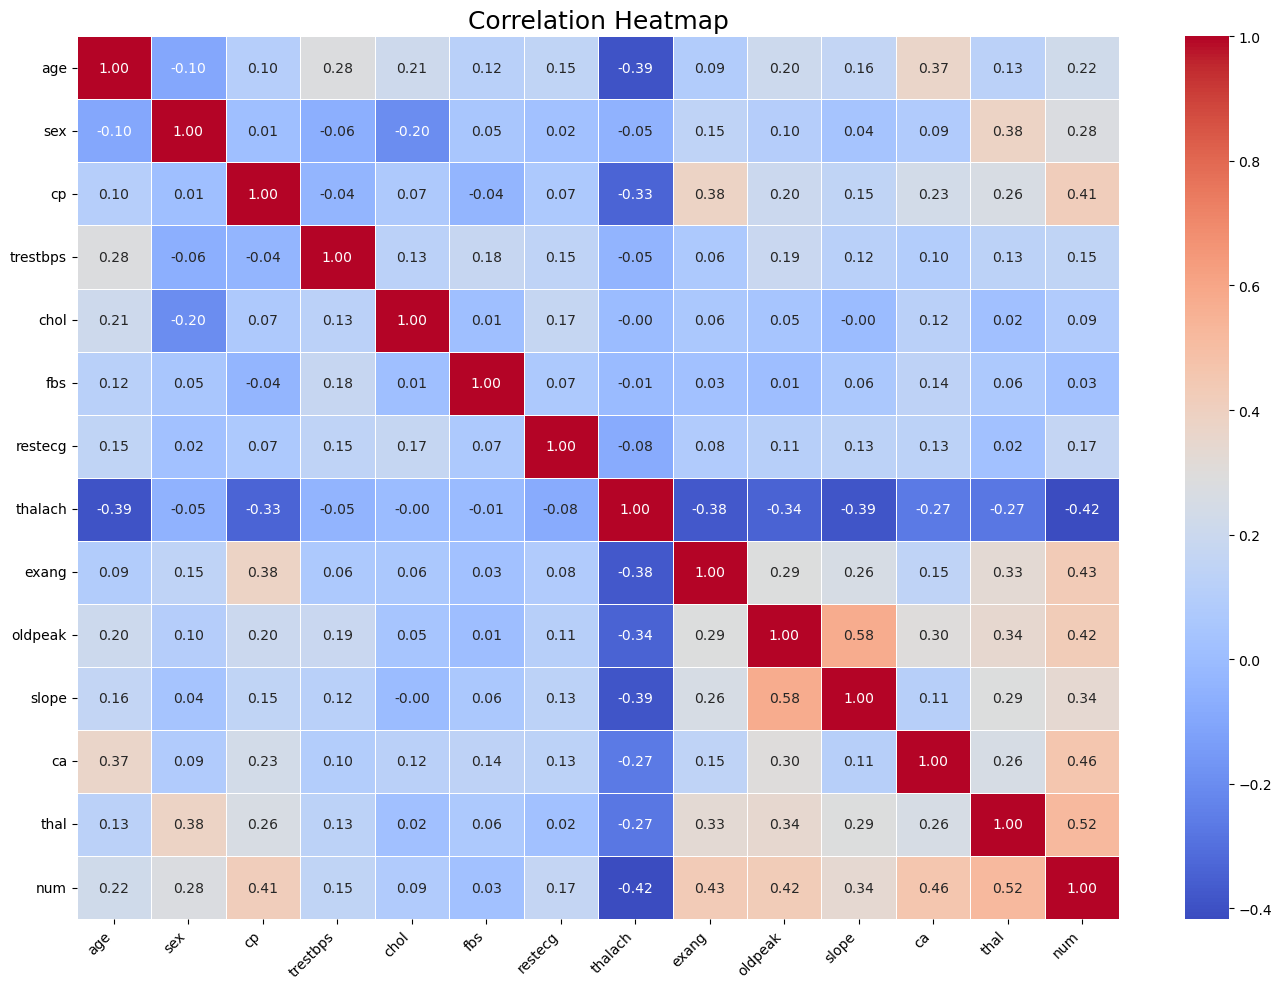

In [10]:
# Correlation Heatmap

plt.figure(figsize=(14, 10))  # Adjust figure size for better visibility
correlation_matrix = X.join(y_binary).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap', size=18)
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.yticks(rotation=0)  # Keep the y labels horizontal
plt.tight_layout()  # Adjust layout to fit the figure size
plt.show()


/Users/ashleshasanjaykadam/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


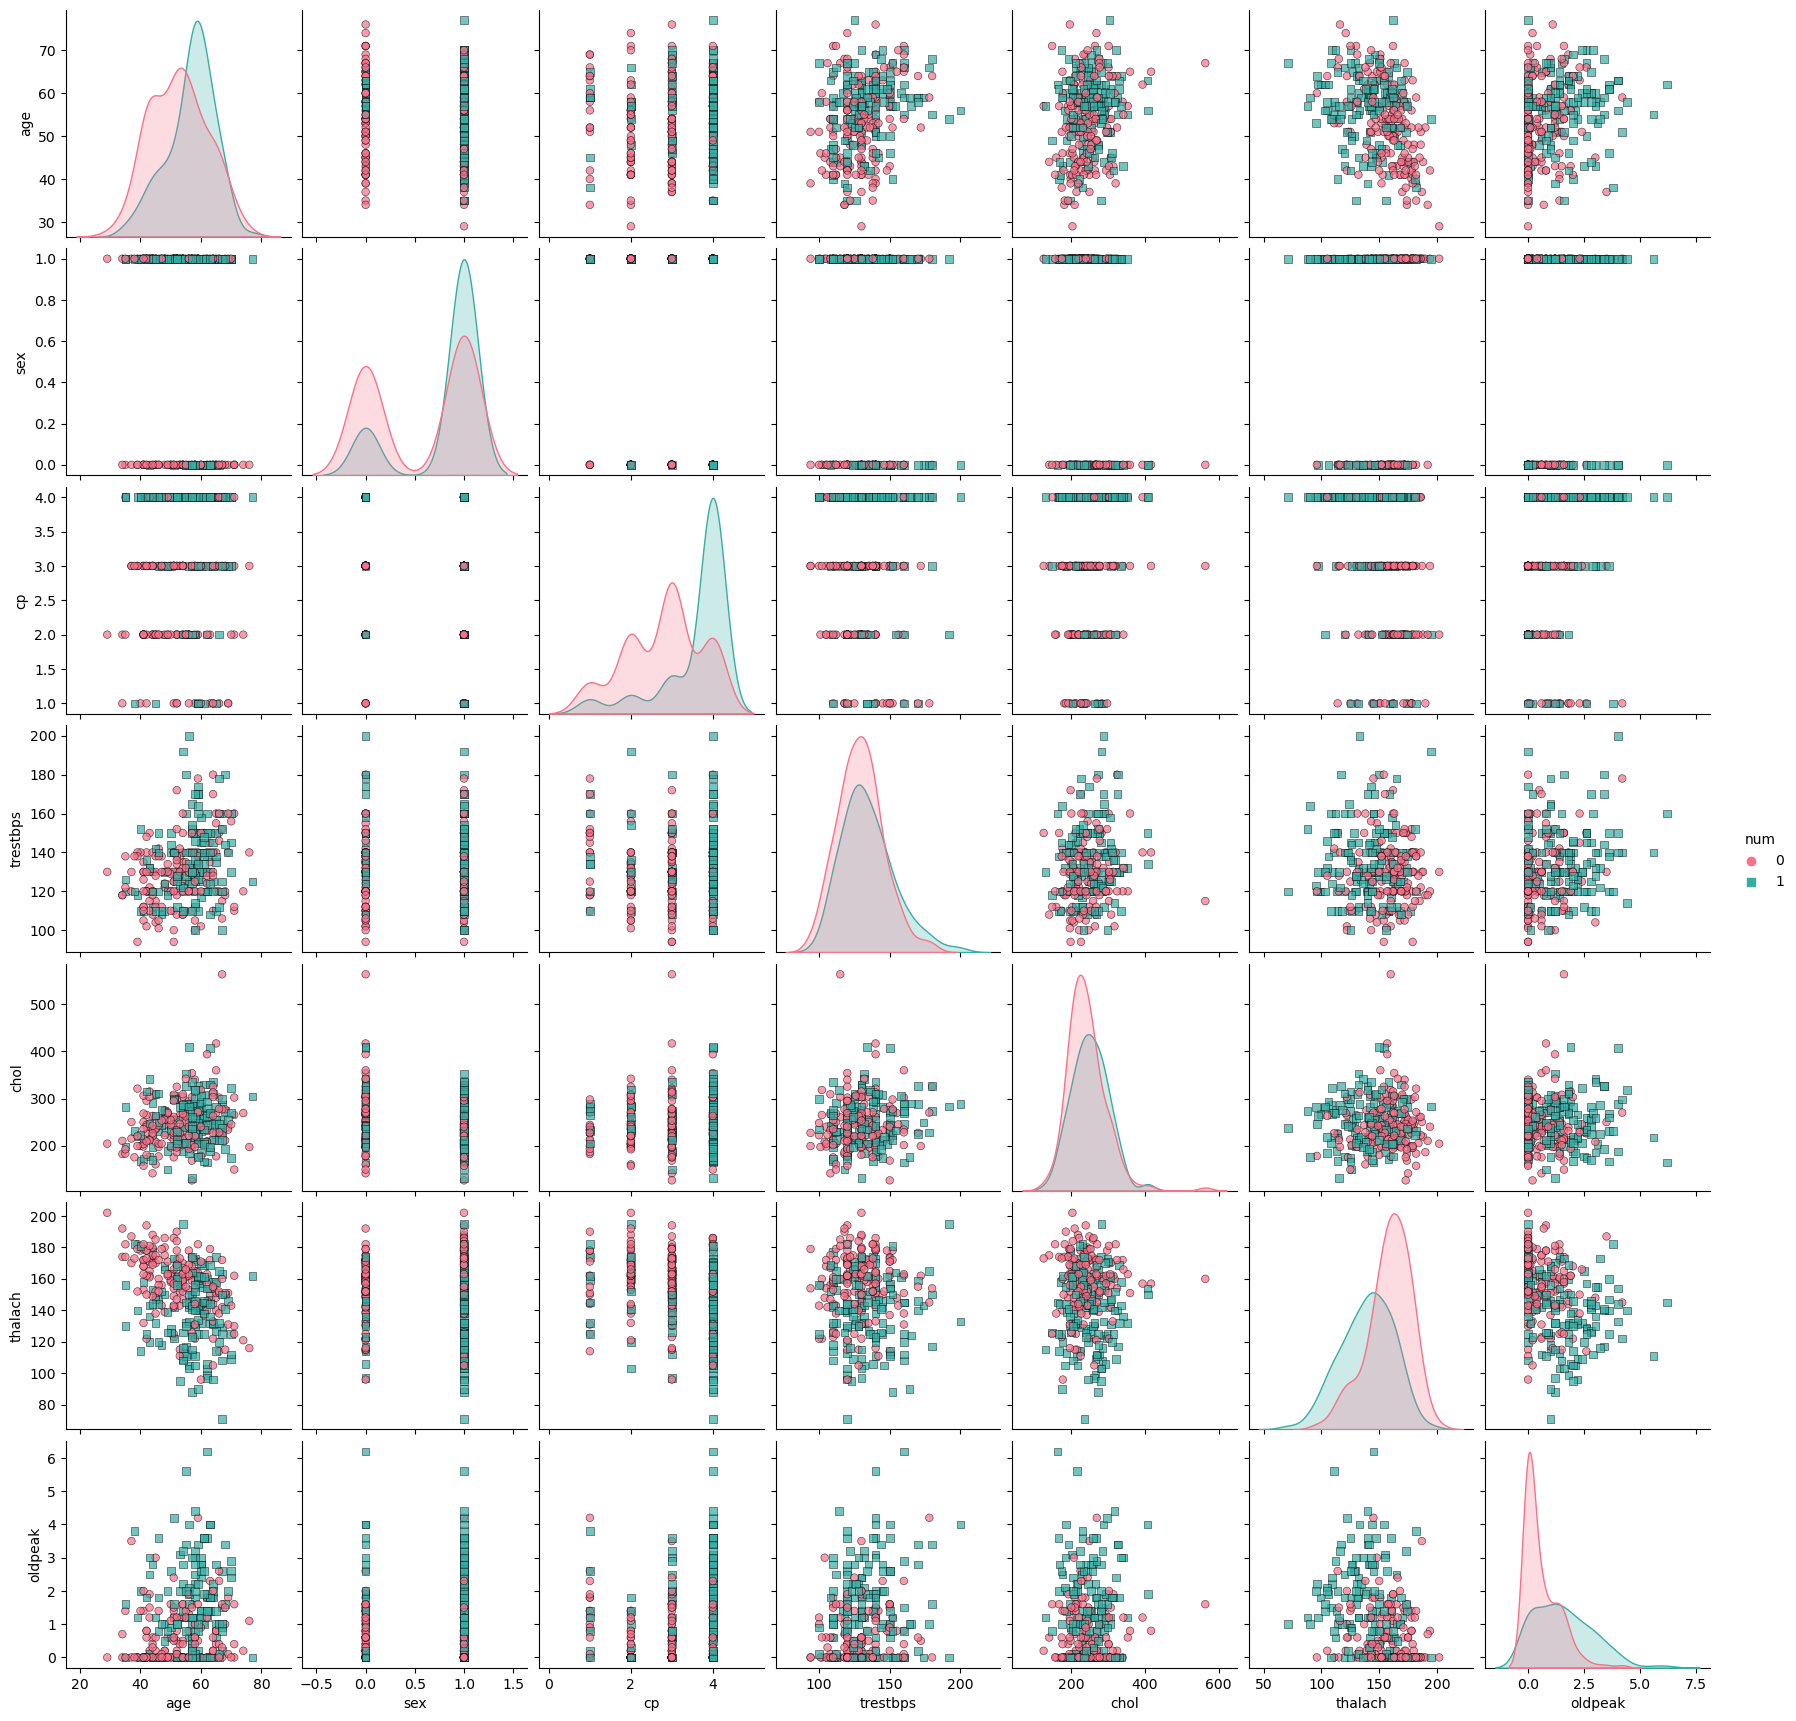

In [11]:
# Pair Plot - might be too much for all features, so selecting a few
# Select the features to be included in the pair plot
selected_features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'num']

# Determine the number of unique values in the 'hue' variable
unique_hue_values = X.join(y_binary)['num'].nunique()

# Create a color palette with the same number of colors as there are unique hue values
palette = sns.color_palette('husl', n_colors=unique_hue_values)

# Create the pair plot with the updated palette
sns.pairplot(
    X.join(y_binary)[selected_features],
    hue='num',
    palette=palette,
    diag_kind='kde',  # Use kernel density estimate for diagonal plots
    markers=["o", "s"],  # Different markers for different categories
    plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},
)

plt.show()


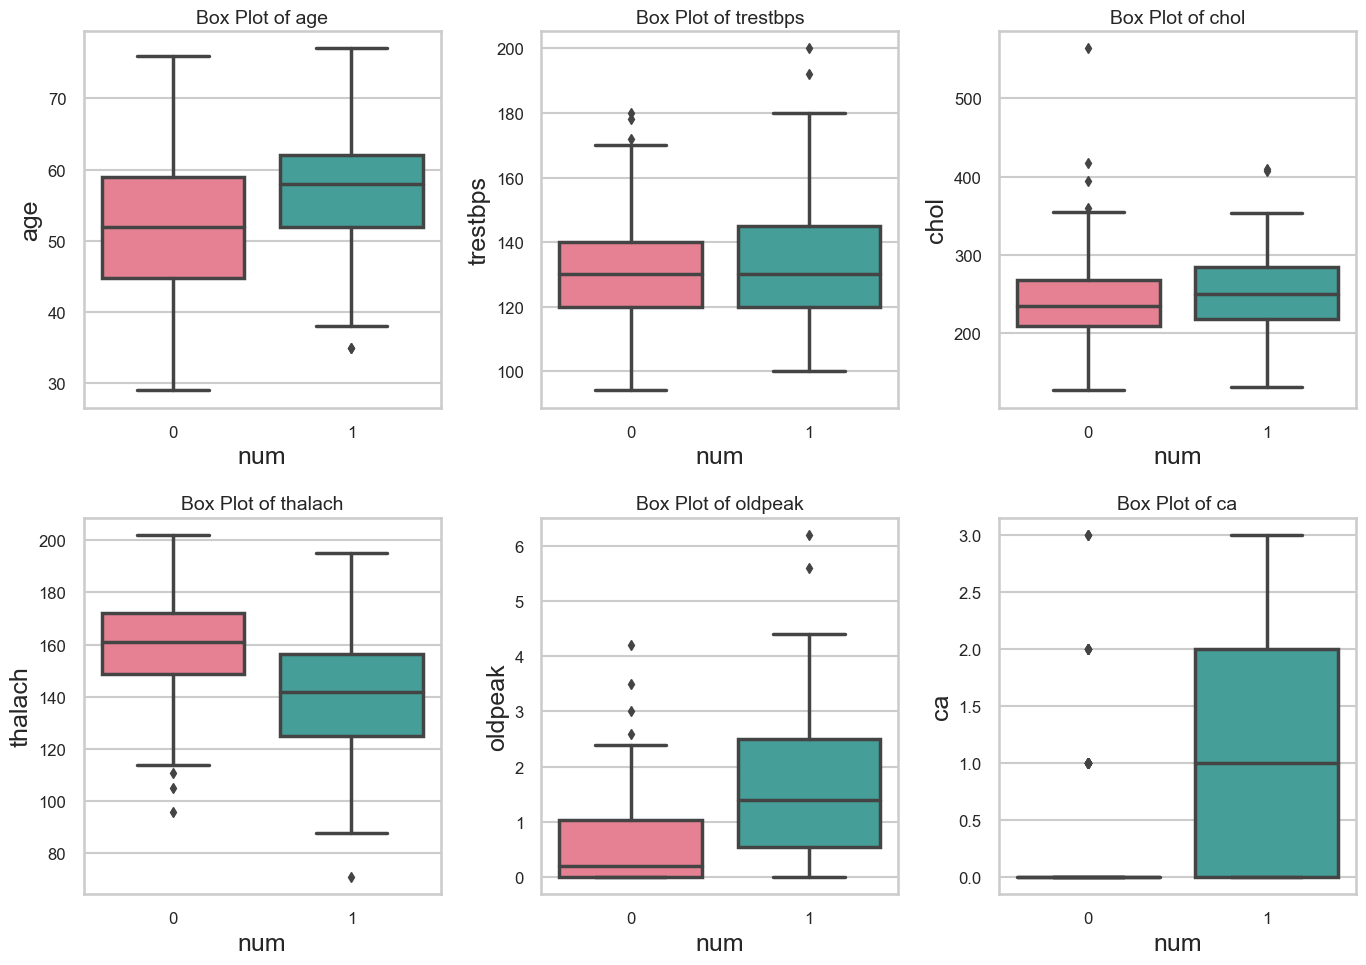

In [12]:
# Box Plots

# Set the style of seaborn and context for better readability
sns.set_style('whitegrid')
sns.set_context('talk')  # or 'notebook', 'paper', 'talk', 'poster'

# Define a color palette
palette = sns.color_palette('husl', n_colors=2)  # A perceptually uniform color space

# Initialize the figure with a logarithmic x axis
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))

# Plot the boxplots
features_to_plot = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
for i, col in enumerate(features_to_plot):
    sns.boxplot(x=y_binary, y=X[col], ax=axes[i//3, i%3], palette=palette, linewidth=2.5)
    axes[i//3, i%3].set_title(f'Box Plot of {col}', fontsize=14)
    axes[i//3, i%3].tick_params(axis='x', labelsize=12)
    axes[i//3, i%3].tick_params(axis='y', labelsize=12)

# Tight layout to adjust spacing
plt.tight_layout()
plt.show()


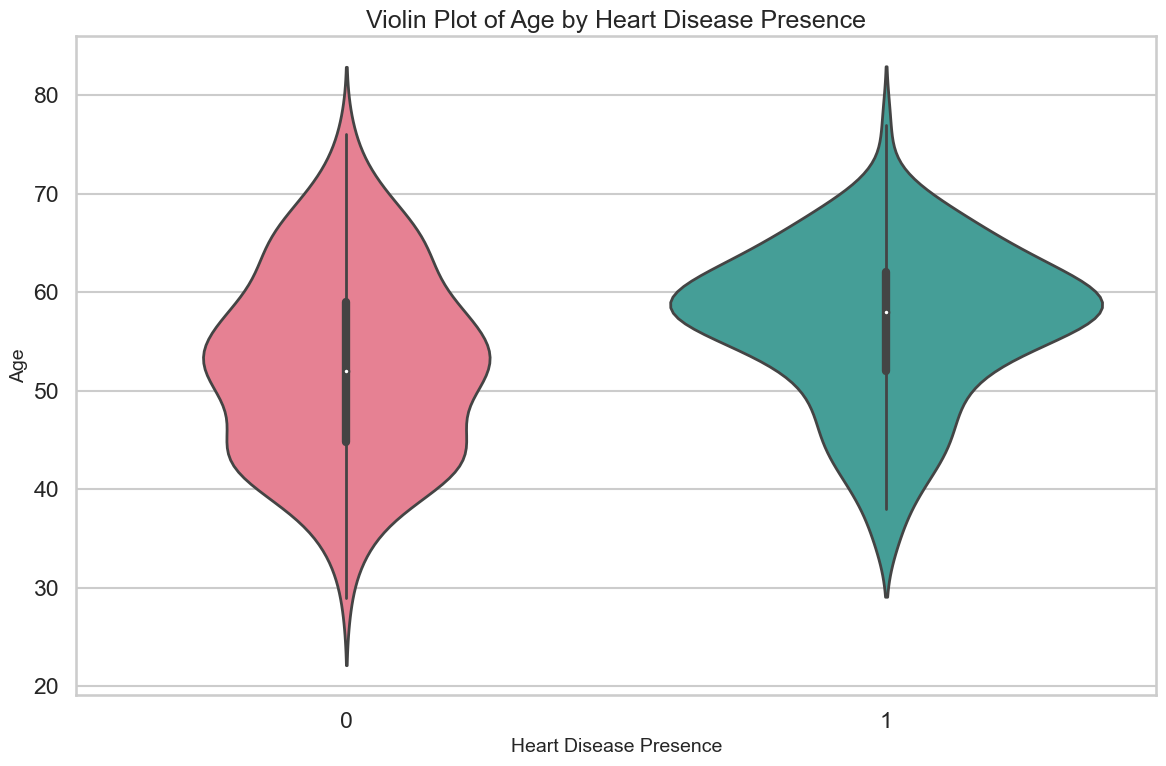

In [13]:
# Violin Plot for Feature Distribution by Class
# Set the style of seaborn and context for better readability
sns.set_style('whitegrid')
sns.set_context('talk')

# Define a vibrant color palette using HUSL color space
palette = sns.color_palette("husl", len(y_binary.unique()))

# Create the violin plot with the vibrant style and palette
plt.figure(figsize=(12, 8))
sns.violinplot(x='num', y='age', data=X.join(y_binary), palette=palette, linewidth=2)

# Set the title and labels with updated font sizes for clarity
plt.title('Violin Plot of Age by Heart Disease Presence', fontsize=18)
plt.xlabel('Heart Disease Presence', fontsize=14)
plt.ylabel('Age', fontsize=14)

# Display the plot
plt.tight_layout()  # Adjust layout to fit the figure size and avoid overlaps
plt.show()

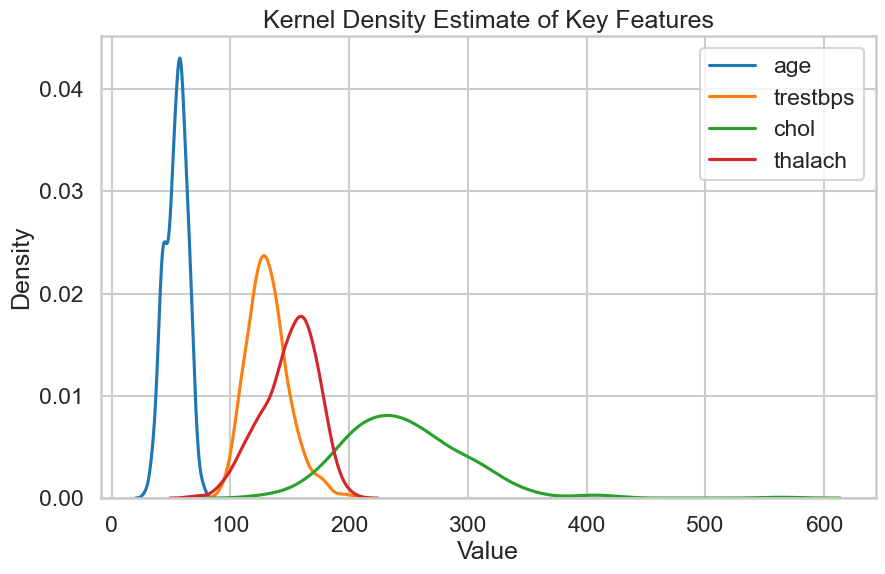

In [14]:
# Feature Distribution Plot with Kernel Density Estimate
plt.figure(figsize=(10, 6))
for feature in ['age', 'trestbps', 'chol', 'thalach']:
    sns.kdeplot(X[feature], label=f'{feature}')
plt.title('Kernel Density Estimate of Key Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

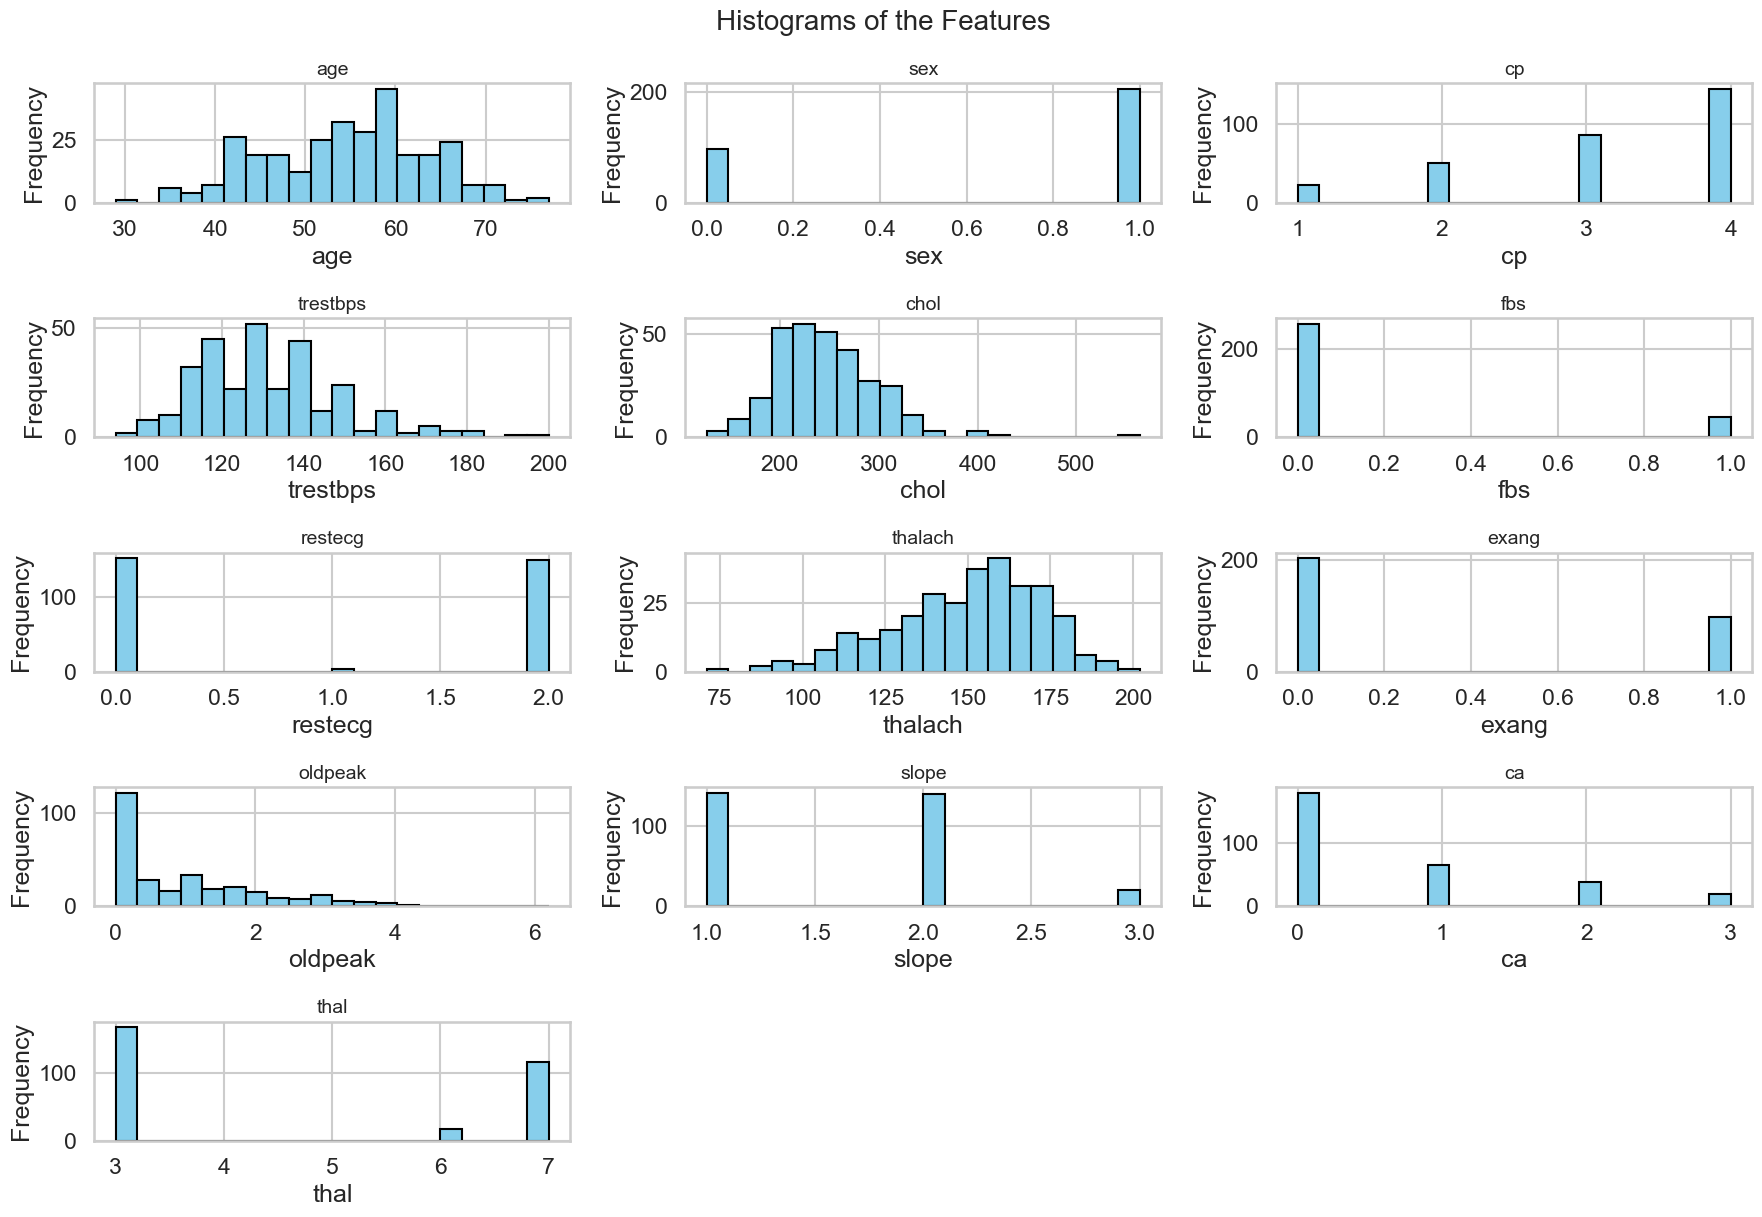

In [15]:
# Histograms
# Set larger figure size for better visibility
plt.figure(figsize=(18, 12))

# Get the number of features to plot
num_features = X.shape[1]

# Calculate the number of rows needed with up to 3 columns
num_rows = (num_features + 2) // 3

# Plot histograms for each feature
for i, column in enumerate(X.columns):
    plt.subplot(num_rows, 3, i + 1)
    X[column].hist(bins=20, color='skyblue', edgecolor='black')
    plt.title(column, fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Set a super title for all subplots
plt.suptitle('Histograms of the Features', fontsize=20, y=1.02)

# Show the plot
plt.show()


In [16]:
# Feature Engineering


# Identify categorical variables and explore their unique values
categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
print("Categorical columns and their unique values:")
for col in categorical_columns:
    print(f"{col} unique values: {X[col].unique()}")

# One-hot encode the categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
print("\nData after encoding categorical features:")
print(X_encoded.head())

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns)
print("\nData after scaling:")
print(X_scaled.head())

Categorical columns and their unique values:

Data after encoding categorical features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

Data after scaling:
        age       sex        cp  trestbps      chol       fbs   restecg  \
0  0.948726  0.686202 -2.251775  0.757525 -0.264900  2.394438  1.016684   
1  1.392002  0.686202  0.877985  1.611220  0.760415 -0.417635  1.016684   
2  1.392002  0.686202  0.877985 -0.665300 -0.342283 -0.417635  1.016684   
3 -1.932564  0

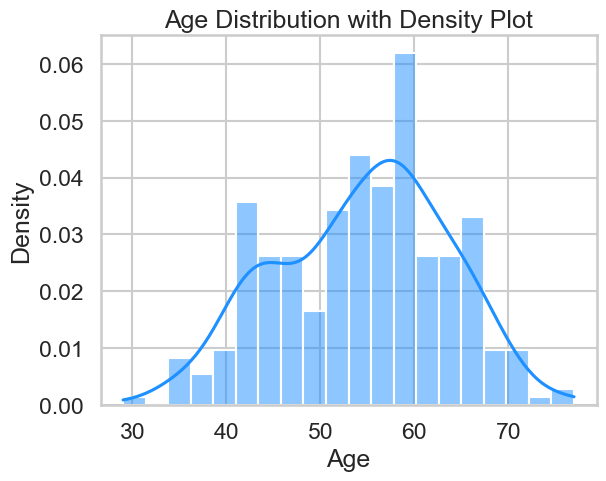

In [17]:
# Density Plot Overlaid with Histogram: for 'age' feature
sns.histplot(X['age'], kde=True, color='dodgerblue', bins=20, stat='density')
plt.title('Age Distribution with Density Plot')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

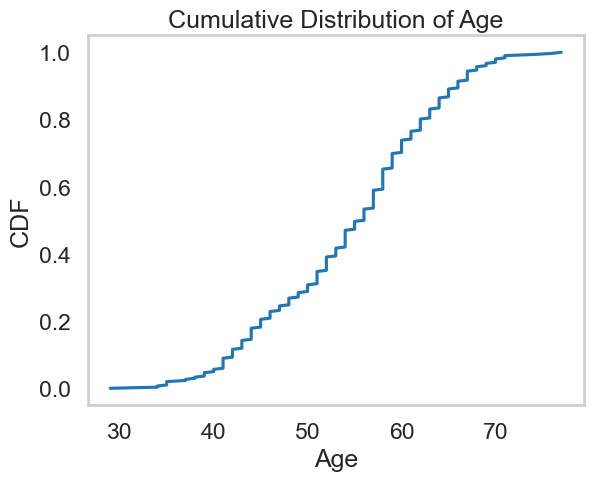

In [18]:
# Cumulative Distribution Function (CDF): for 'age' feature
age_sorted = np.sort(X['age'])
p = np.arange(len(age_sorted)) / (len(age_sorted) - 1)
plt.plot(age_sorted, p)
plt.title('Cumulative Distribution of Age')
plt.xlabel('Age')
plt.ylabel('CDF')
plt.grid()
plt.show()

In [19]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.3, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 212 samples
Testing set size: 91 samples


In [20]:
# Building and training the model

model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the logistic regression model: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy of the logistic regression model: 0.85
Confusion Matrix:
[[39  9]
 [ 5 38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        48
           1       0.81      0.88      0.84        43

    accuracy                           0.85        91
   macro avg       0.85      0.85      0.85        91
weighted avg       0.85      0.85      0.85        91



In [21]:
# Cross-Validation

scores = cross_val_score(model, X_scaled, y_binary, cv=10)  # 10-fold cross-validation
print("Cross-validation scores:", scores)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.87096774 0.80645161 0.80645161 0.96666667 0.8        0.66666667
 0.86666667 0.83333333 0.7        0.86666667]
Average cross-validation score: 0.82


In [22]:
# Re-train and Evaluate the Model with Optimal Parameters

optimal_model = LogisticRegression(C=0.01, solver='lbfgs')
optimal_model.fit(X_train, y_train)
y_pred_optimal = optimal_model.predict(X_test)

# Evaluate the optimized model
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"Optimized model accuracy: {accuracy_optimal:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))

Optimized model accuracy: 0.86
Confusion Matrix:
[[43  5]
 [ 8 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.88      0.81      0.84        43

    accuracy                           0.86        91
   macro avg       0.86      0.85      0.86        91
weighted avg       0.86      0.86      0.86        91



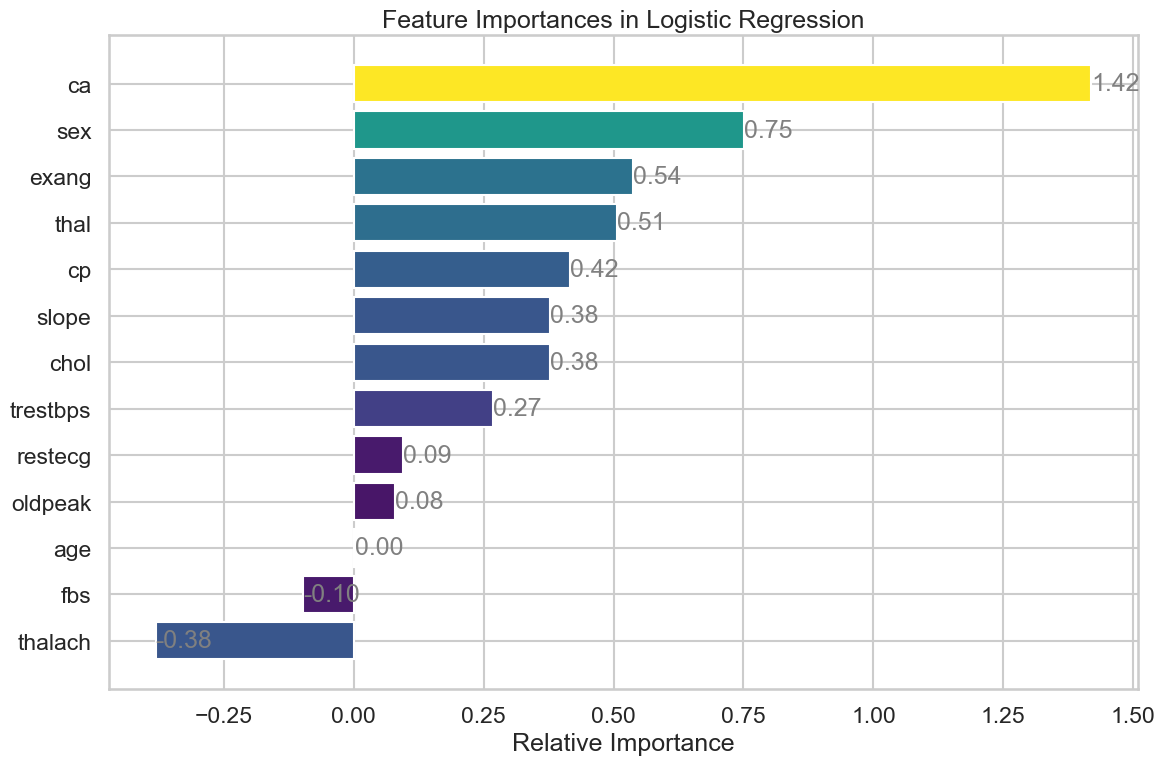

In [23]:
# Visualizing Feature Importance
importance = model.coef_[0]
features = X_encoded.columns
indices = np.argsort(importance)

# Choose a color palette
colors = plt.cm.viridis(np.abs(importance[indices]) / np.max(np.abs(importance[indices])))

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importance[indices], color=colors)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importances in Logistic Regression')

# Annotate the bars with the coefficient values
for i in range(len(indices)):
    plt.text(importance[indices][i], i, f"{importance[indices][i]:.2f}", color='gray', va='center')

plt.tight_layout()
plt.show()

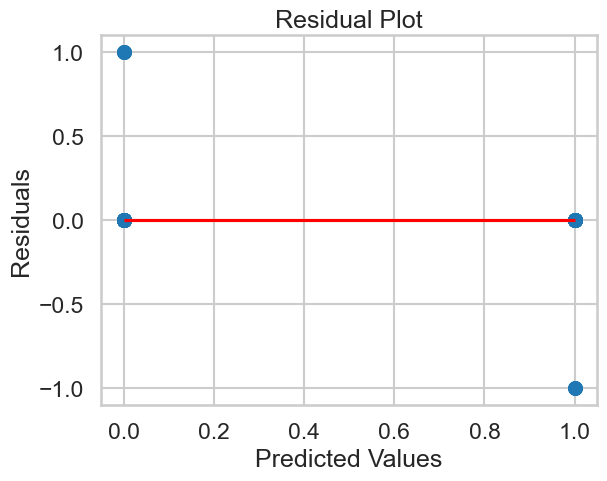

In [24]:
# Residual Plot
residuals = y_test - y_pred_optimal

plt.figure()
plt.scatter(y_pred_optimal, residuals)
plt.hlines(y=0, xmin=y_pred_optimal.min(), xmax=y_pred_optimal.max(), colors='red')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

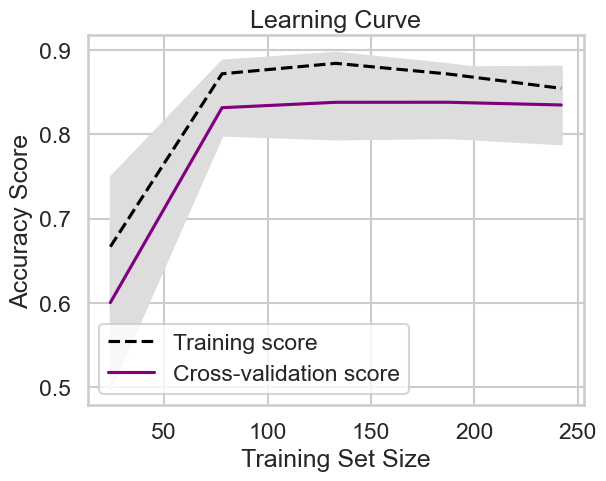

In [25]:

train_sizes, train_scores, test_scores = learning_curve(optimal_model, X_scaled, y_binary, n_jobs=-1, cv=StratifiedKFold(n_splits=5), train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, '--', color="black", label="Training score")
plt.plot(train_sizes, test_mean, color="purple", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc="best")
plt.show()

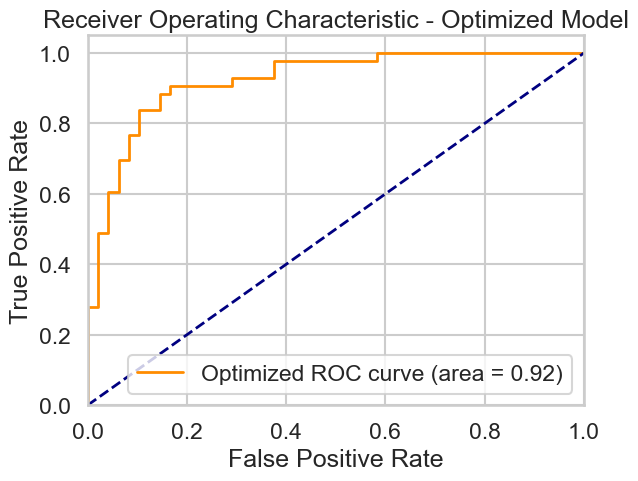

In [26]:
# ROC Curve and AUC

# Compute probabilities for the AUC score
y_scores_optimal = optimal_model.decision_function(X_test)
fpr_optimal, tpr_optimal, _ = roc_curve(y_test, y_scores_optimal)
roc_auc_optimal = auc(fpr_optimal, tpr_optimal)

# Plot ROC curve for the optimized model
plt.figure()
plt.plot(fpr_optimal, tpr_optimal, color='darkorange', lw=2, label='Optimized ROC curve (area = %0.2f)' % roc_auc_optimal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Optimized Model')
plt.legend(loc="lower right")
plt.show()

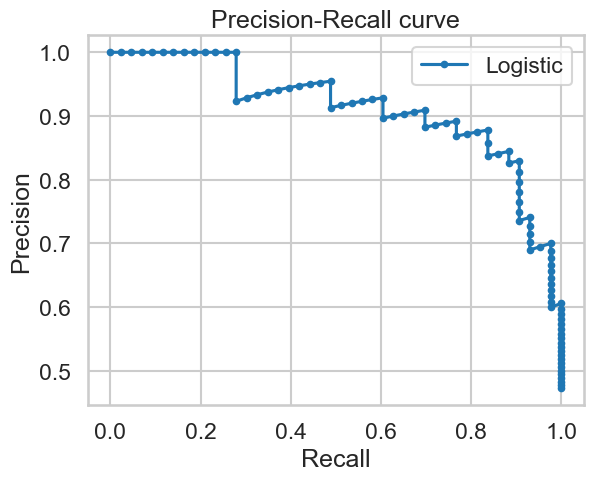

In [27]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_scores_optimal)

plt.figure()
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

In [28]:
# Evaluating Model Sensitivity to Data Partitioning

# Cross-validation with StratifiedKFold
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(model, X_scaled, y_binary, cv=skf, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average score across different partitions:", scores.mean())

Cross-validation scores: [0.85245902 0.8852459  0.78688525 0.81666667 0.8       ]
Average score across different partitions: 0.8282513661202184
